## Horizontal Spectra of Tracers

In [12]:
from scipy.io import loadmat
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import xrft 

import gsw

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [3]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
data_659 = data_dir+'/data/interim/gliders/sg659/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660/CTD_660.nc'

ds_659 = xr.load_dataset(data_659)
ds_660 = xr.load_dataset(data_660)

In [4]:
# Calculate a time axis as YTD
days = ds_659.time - np.datetime64('2019-01-01')
days_round_659 = (days / np.timedelta64(1, 'D')).round()
ds_659['days'] = (days / np.timedelta64(1, 'D'))

days = ds_660.time - np.datetime64('2019-01-01')
days_round_660 = (days / np.timedelta64(1, 'D')).round()
ds_660['days'] = (days / np.timedelta64(1, 'D'))

In [5]:
# Calculate an along glider path distance axis
dist_659 = gt.utils.distance(ds_659.longitude, 
                       ds_659.latitude)

ds_659['distance'] = xr.DataArray(np.cumsum(dist_659), 
                           dims= ['ctd_data_point'])

dist_660 = gt.utils.distance(ds_660.longitude, 
                       ds_660.latitude)
ds_660['distance'] = xr.DataArray(np.cumsum(dist_660), 
                           dims= ['ctd_data_point'])

In [6]:
# Calculate the potential density
ds_659['potdens'] = gt.physics.potential_density(ds_659.salinity, 
                                                 ds_659.temperature, 
                                                 ds_659.pressure, 
                                                 ds_659.latitude, 
                                                 ds_659.longitude)

ds_660['potdens'] = gt.physics.potential_density(ds_660.salinity, 
                                                 ds_660.temperature, 
                                                 ds_660.pressure,
                                                 ds_660.latitude, 
                                                 ds_660.longitude)


In [7]:
# Calculate the spice based on the TEOS10 function
# 
# It remains unclear to me if this is the right thing to do, 
# or should we be using a locally referenced variable. 
# Discuss and iterate on this. 

ds_659['spice'] = gt.physics.spice0(ds_659.salinity, 
                         ds_659.temperature, 
                         ds_659.pressure, 
                         ds_659.latitude, 
                         ds_659.longitude)

ds_660['spice'] = gt.physics.spice0(ds_660.salinity, 
                         ds_660.temperature, 
                         ds_660.pressure, 
                         ds_660.latitude, 
                         ds_660.longitude)

## Frequency Spectra

### Pressure - time 

In [8]:
# Interpolate and grid glider data on pressure-time axis

# Note this is different from what glidertools does, which does a simple binning. 

from scipy.interpolate import griddata
# interpolate on pressure-time 
def interp_pres_time(ds_glid, var): 
    pres_ug = ds_glid.pressure
    time_ug = ds_glid.days
    
    # convert to points values
    points = np.stack([time_ug.values, pres_ug.values],
                       axis=1)
    values = ds_glid[var].values
    
    # remove nans
    non_nan = np.logical_and(np.logical_and(~np.isnan(points[:,0]), 
                                      ~np.isnan(points[:,1])),
                                      ~np.isnan(values))
    
    points =points[non_nan,:]
    values =values[non_nan]
    
    # define grid
    # choose grid size that smaller than most of the sampling points 
    # so we avoid aliasing in this step.
    pres_grid = np.linspace(0,1000,2001) 
    time_grid = np.arange(119, 207, 0.025)
    grid_p, grid_t = np.meshgrid(pres_grid, time_grid)
    
    temp_grided = griddata(points, values, 
                         (grid_t, grid_p), 
                         method='linear', rescale=True)
    
    return xr.DataArray(temp_grided.T, 
                               dims=["pressure", "time"],
                          coords={"pressure":pres_grid,
                                    "time":time_grid}).rename(var)

# apply to all useful glider variables 
# can later add in variables measured by other instruments too 
def convert_glider(ds_glid, vars_convert= ['temperature','salinity','potdens','spice']):
    
    #vars_convert = ['temperature','salinity','potdens']
    
    ds_grid = xr.Dataset()
    
    for v in vars_convert:
            ds_grid[v] = interp_pres_time(ds_glid, v)
    
    return ds_grid

In [9]:
# convert from point data to gridded data, can take some time
ds_659_grid = convert_glider(ds_659)
ds_660_grid = convert_glider(ds_660)

In [47]:
depth_range = slice(40, 960)

temp_spec_659 = xrft.power_spectrum(ds_659_grid.temperature.sel(pressure=depth_range).dropna(dim='time'),
                               dim='time', window=True)
salt_spec_659 = xrft.power_spectrum(ds_659_grid.salinity.sel(pressure=depth_range).dropna(dim='time'),
                               dim='time', window=True)
dens_spec_659 = xrft.power_spectrum(ds_659_grid.potdens.sel(pressure=depth_range).dropna(dim='time'),
                               dim='time', window=True)

temp_spec_660 = xrft.power_spectrum(ds_660_grid.temperature.sel(pressure=depth_range).dropna(dim='time'),
                               dim='time', window=True)
salt_spec_660 = xrft.power_spectrum(ds_660_grid.salinity.sel(pressure=depth_range).dropna(dim='time'),
                               dim='time', window=True)
dens_spec_660 = xrft.power_spectrum(ds_660_grid.potdens.sel(pressure=depth_range).dropna(dim='time'),
                               dim='time', window=True)

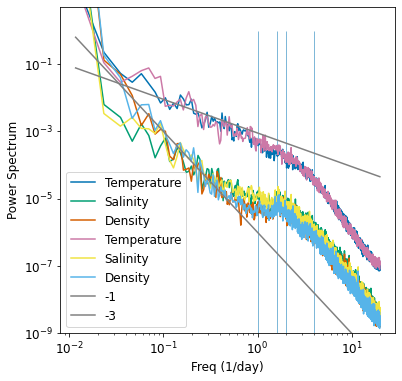

In [49]:
plt.figure(figsize=(6,6))
temp_spec_659.mean('pressure').plot(label='Temperature')
salt_spec_659.mean('pressure').plot(label='Salinity')
dens_spec_659.mean('pressure').plot(label='Density')

temp_spec_660.mean('pressure').plot(label='Temperature')
salt_spec_660.mean('pressure').plot(label='Salinity')
dens_spec_660.mean('pressure').plot(label='Density')


plt.plot(temp_spec_659.freq_time, 0.9e-3*temp_spec_659.freq_time**(-1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 1e-6*temp_spec_659.freq_time**-3, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum')
plt.title('')
plt.legend()

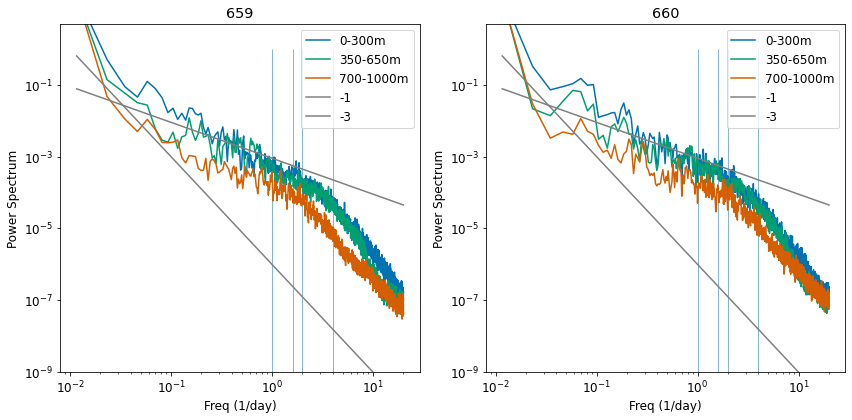

In [46]:
plt.figure(figsize=(12,6))

plt.subplot(121)
temp_spec_659.sel(pressure=slice(0,300)).mean('pressure').plot(label='0-300m')
temp_spec_659.sel(pressure=slice(350,650)).mean('pressure').plot(label='350-650m')
temp_spec_659.sel(pressure=slice(700,1000)).mean('pressure').plot(label='700-1000m')


plt.plot(temp_spec_659.freq_time, 0.9e-3*temp_spec_659.freq_time**(-1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 1e-6*temp_spec_659.freq_time**-3, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum')
plt.title('659')
plt.legend()

plt.subplot(122)
temp_spec_660.sel(pressure=slice(0,300)).mean('pressure').plot(label='0-300m')
temp_spec_660.sel(pressure=slice(350,650)).mean('pressure').plot(label='350-650m')
temp_spec_660.sel(pressure=slice(700,1000)).mean('pressure').plot(label='700-1000m')


plt.plot(temp_spec_659.freq_time, 0.9e-3*temp_spec_659.freq_time**(-1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 1e-6*temp_spec_659.freq_time**-3, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum')
plt.title('660')
plt.legend()

plt.tight_layout()

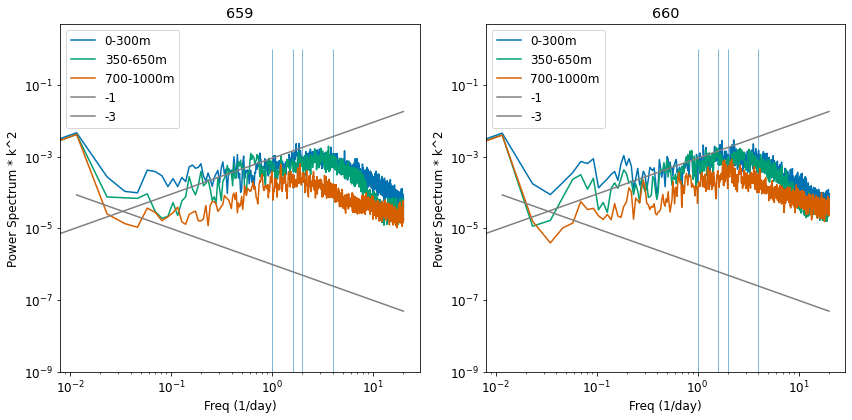

In [51]:
plt.figure(figsize=(12,6))

plt.subplot(121)
(temp_spec_659.freq_time**2*temp_spec_659).sel(pressure=slice(0,300)).mean('pressure').plot(label='0-300m')
(temp_spec_659.freq_time**2*temp_spec_659).sel(pressure=slice(350,650)).mean('pressure').plot(label='350-650m')
(temp_spec_659.freq_time**2*temp_spec_659).sel(pressure=slice(700,1000)).mean('pressure').plot(label='700-1000m')


plt.plot(temp_spec_659.freq_time, 0.9e-3*temp_spec_659.freq_time**(1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 1e-6*temp_spec_659.freq_time**-1, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum * k^2')
plt.title('659')
plt.legend()

plt.subplot(122)
(temp_spec_660.freq_time**2*temp_spec_660).sel(pressure=slice(0,300)).mean('pressure').plot(label='0-300m')
(temp_spec_660.freq_time**2*temp_spec_660).sel(pressure=slice(350,650)).mean('pressure').plot(label='350-650m')
(temp_spec_660.freq_time**2*temp_spec_660).sel(pressure=slice(700,1000)).mean('pressure').plot(label='700-1000m')


plt.plot(temp_spec_659.freq_time, 0.9e-3*temp_spec_659.freq_time**(1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 1e-6*temp_spec_659.freq_time**-1, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum * k^2')
plt.title('660')
plt.legend()


plt.tight_layout()

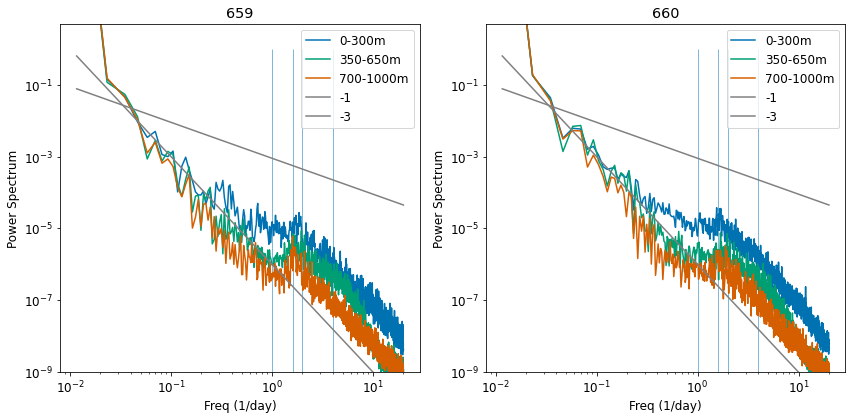

In [45]:
plt.figure(figsize=(12,6))

plt.subplot(121)
dens_spec_659.sel(pressure=slice(0,150)).mean('pressure').plot(label='0-300m')
dens_spec_659.sel(pressure=slice(350,650)).mean('pressure').plot(label='350-650m')
dens_spec_659.sel(pressure=slice(700,1000)).mean('pressure').plot(label='700-1000m')


plt.plot(temp_spec_659.freq_time, 0.9e-3*temp_spec_659.freq_time**(-1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 1e-6*temp_spec_659.freq_time**-3, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum')
plt.title('659')
plt.legend()

plt.subplot(122)
dens_spec_660.sel(pressure=slice(0,300)).mean('pressure').plot(label='0-300m')
dens_spec_660.sel(pressure=slice(350,650)).mean('pressure').plot(label='350-650m')
dens_spec_660.sel(pressure=slice(700,1000)).mean('pressure').plot(label='700-1000m')


plt.plot(temp_spec_659.freq_time, 0.9e-3*temp_spec_659.freq_time**(-1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 1e-6*temp_spec_659.freq_time**-3, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum')
plt.title('660')
plt.legend()

plt.tight_layout()

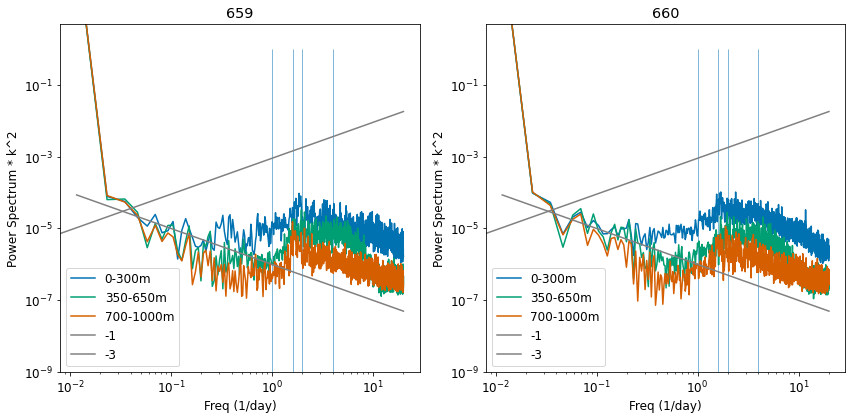

In [115]:
plt.figure(figsize=(12,6))

plt.subplot(121)
(temp_spec_659.freq_time**2*dens_spec_659).sel(pressure=slice(0,150)).mean('pressure').plot(label='0-300m')
(temp_spec_659.freq_time**2*dens_spec_659).sel(pressure=slice(350,650)).mean('pressure').plot(label='350-650m')
(temp_spec_659.freq_time**2*dens_spec_659).sel(pressure=slice(700,1000)).mean('pressure').plot(label='700-1000m')


plt.plot(temp_spec_659.freq_time, 0.9e-3*temp_spec_659.freq_time**(1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 1e-6*temp_spec_659.freq_time**-1, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum * k^2')
plt.title('659')
plt.legend()

plt.subplot(122)
(temp_spec_660.freq_time**2*dens_spec_660).sel(pressure=slice(0,300)).mean('pressure').plot(label='0-300m')
(temp_spec_660.freq_time**2*dens_spec_660).sel(pressure=slice(350,650)).mean('pressure').plot(label='350-650m')
(temp_spec_660.freq_time**2*dens_spec_660).sel(pressure=slice(700,1000)).mean('pressure').plot(label='700-1000m')


plt.plot(temp_spec_659.freq_time, 0.9e-3*temp_spec_659.freq_time**(1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 1e-6*temp_spec_659.freq_time**-1, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum * k^2')
plt.title('660')
plt.legend()

plt.tight_layout()

### Density - time

In [10]:
def interp_dens_time(ds_glid, var): 
    dens_ug = ds_glid.potdens
    time_ug = ds_glid.days
    
    # convert to points values
    points = np.stack([time_ug.values, dens_ug.values],
                       axis=1)
    values = ds_glid[var].values
    
    # remove nans
    non_nan = np.logical_and(np.logical_and(~np.isnan(points[:,0]), 
                                      ~np.isnan(points[:,1])),
                                      ~np.isnan(values))
    
    points =points[non_nan,:]
    values =values[non_nan]
    
    # define grid
    dens_grid = np.linspace(1026.8,1027.8,1001)
    time_grid = np.arange(119, 207, 0.025)
    grid_d, grid_t = np.meshgrid(dens_grid, time_grid)
    
    temp_grided = griddata(points, values, 
                         (grid_t, grid_d), 
                         method='linear', rescale=True)
    
    return xr.DataArray(temp_grided.T, 
                               dims=["potdens", "time"],
                          coords={"potdens":dens_grid,
                                    "time":time_grid}).rename(var)

def convert_glider_dens(ds_glid, vars_convert= ['temperature','salinity','pressure','spice','latitude','longitude']):
       
    ds_grid = xr.Dataset()
    
    for v in vars_convert:
            ds_grid[v] = interp_dens_time(ds_glid, v)
    
    return ds_grid

In [11]:
ds_659_iso = convert_glider_dens(ds_659)
ds_660_iso = convert_glider_dens(ds_660)

In [65]:
ds_659_iso

<xarray.Dataset>
Dimensions:      (potdens: 1001, time: 3520)
Coordinates:
  * potdens      (potdens) float64 1.027e+03 1.027e+03 ... 1.028e+03 1.028e+03
  * time         (time) float64 119.0 119.0 119.1 119.1 ... 206.9 207.0 207.0
Data variables:
    temperature  (potdens, time) float64 nan nan nan nan nan ... nan nan nan nan
    salinity     (potdens, time) float64 nan nan nan nan nan ... nan nan nan nan
    pressure     (potdens, time) float64 nan nan nan nan nan ... nan nan nan nan
    spice        (potdens, time) float64 nan nan nan nan nan ... nan nan nan nan
    latitude     (potdens, time) float64 nan nan nan nan nan ... nan nan nan nan
    longitude    (potdens, time) float64 nan nan nan nan nan ... nan nan nan nan

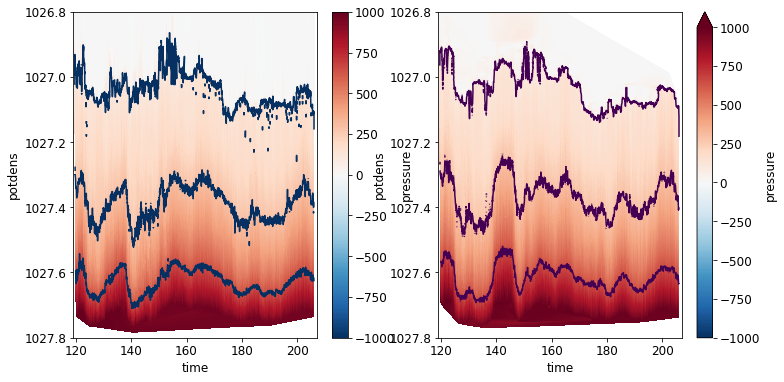

In [95]:
plt.figure(figsize=(12,6))

plt.subplot(121)
ds_659_iso.pressure.plot()
ds_659_iso.pressure.plot.contour(levels=[100])
ds_659_iso.pressure.plot.contour(levels=[300])
ds_659_iso.pressure.plot.contour(levels=[650])

plt.gca().invert_yaxis()

plt.subplot(122)
ds_660_iso.pressure.plot(vmin=-1000, vmax=1000, cmap='RdBu_r')
ds_660_iso.pressure.plot.contour(levels=[100])
ds_660_iso.pressure.plot.contour(levels=[300])
ds_660_iso.pressure.plot.contour(levels=[650])

plt.gca().invert_yaxis()

In [68]:
iso_range = slice(1026.82, 1027.7)

temp_spec_659_iso = xrft.power_spectrum(ds_659_iso.temperature.sel(potdens=iso_range).dropna(dim='time'),
                               dim='time', window=True)
salt_spec_659_iso = xrft.power_spectrum(ds_659_iso.salinity.sel(potdens=iso_range).dropna(dim='time'),
                               dim='time', window=True)
pres_spec_659_iso = xrft.power_spectrum(ds_659_iso.pressure.sel(potdens=iso_range).dropna(dim='time'),
                               dim='time', window=True)


temp_spec_660_iso = xrft.power_spectrum(ds_660_iso.temperature.sel(potdens=iso_range).dropna(dim='time'),
                               dim='time', window=True)
salt_spec_660_iso = xrft.power_spectrum(ds_660_iso.salinity.sel(potdens=iso_range).dropna(dim='time'),
                               dim='time', window=True)
pres_spec_660_iso = xrft.power_spectrum(ds_660_iso.pressure.sel(potdens=iso_range).dropna(dim='time'),
                               dim='time', window=True)

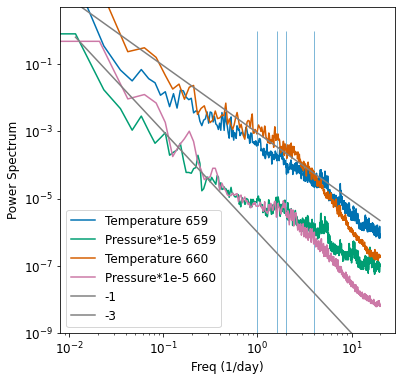

In [118]:
plt.figure(figsize=(6,6))
temp_spec_659_iso.mean('potdens').plot(label='Temperature 659')
#salt_spec_659_iso.mean('pressure').plot(label='Salinity')
(1e-6*pres_spec_659_iso).mean('potdens').plot(label='Pressure*1e-5 659')

temp_spec_660_iso.mean('potdens').plot(label='Temperature 660')
#salt_spec_660_iso.mean('pressure').plot(label='Salinity')
(1e-6*pres_spec_660_iso).mean('potdens').plot(label='Pressure*1e-5 660')

plt.plot(temp_spec_659_iso.freq_time, 0.9e-3*temp_spec_659_iso.freq_time**(-2), label='-1', color='gray')
plt.plot(temp_spec_659_iso.freq_time, 1e-6*temp_spec_659_iso.freq_time**-3, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum')
plt.title('')
plt.legend()

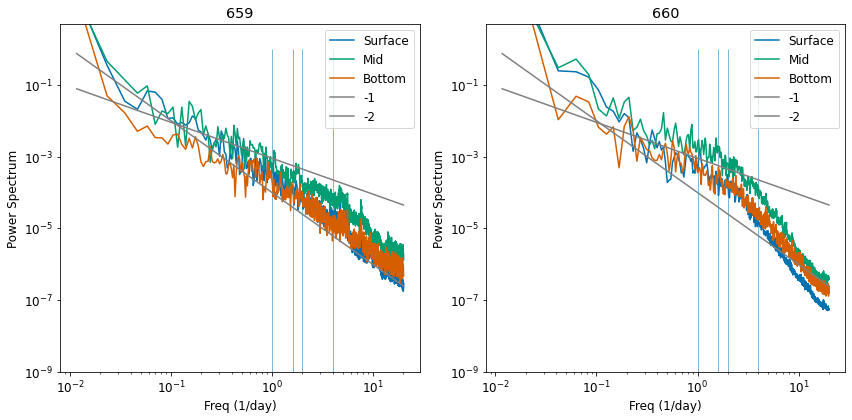

In [119]:
plt.figure(figsize=(12,6))

plt.subplot(121)
temp_spec_659_iso.sel(potdens=slice(1026, 1027.3)).mean('potdens').plot(label='Surface')
temp_spec_659_iso.sel(potdens=slice(1027.3, 1027.6)).mean('potdens').plot(label='Mid')
temp_spec_659_iso.sel(potdens=slice(1027.6, 1027.9)).mean('potdens').plot(label='Bottom')


plt.plot(temp_spec_659.freq_time, 0.9e-3*temp_spec_659.freq_time**(-1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 1e-4*temp_spec_659.freq_time**-2, label='-2', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum')
plt.title('659')
plt.legend()

plt.subplot(122)
temp_spec_660_iso.sel(potdens=slice(1026, 1027.3)).mean('potdens').plot(label='Surface')
temp_spec_660_iso.sel(potdens=slice(1027.3, 1027.6)).mean('potdens').plot(label='Mid')
temp_spec_660_iso.sel(potdens=slice(1027.6, 1027.9)).mean('potdens').plot(label='Bottom')

plt.plot(temp_spec_659.freq_time, 0.9e-3*temp_spec_659.freq_time**(-1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 1e-4*temp_spec_659.freq_time**-2, label='-2', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum')
plt.title('660')
plt.legend()

plt.tight_layout()

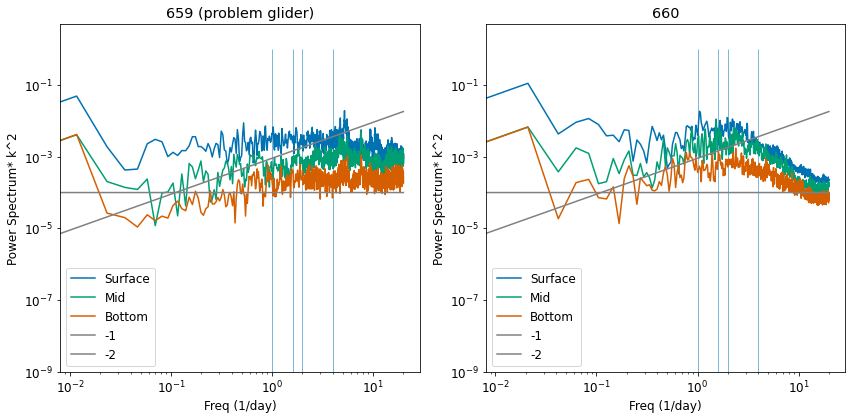

In [113]:
plt.figure(figsize=(12,6))

plt.subplot(121)
(10*temp_spec_659_iso.freq_time**2*temp_spec_659_iso).sel(potdens=slice(1026, 1027.3)).mean('potdens').plot(label='Surface')
(temp_spec_659_iso.freq_time**2*temp_spec_659_iso).sel(potdens=slice(1027.4, 1027.6)).mean('potdens').plot(label='Mid')
(temp_spec_659_iso.freq_time**2*temp_spec_659_iso).sel(potdens=slice(1027.6, 1027.9)).mean('potdens').plot(label='Bottom')


plt.plot(temp_spec_659.freq_time, 0.9e-3*temp_spec_659.freq_time**(1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 1e-4*temp_spec_659.freq_time**0, label='-2', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum* k^2')
plt.title('659 (problem glider)')
plt.legend()

plt.subplot(122)
(10*temp_spec_660_iso.freq_time**2*temp_spec_660_iso).sel(potdens=slice(1026, 1027.3)).mean('potdens').plot(label='Surface')
(temp_spec_660_iso.freq_time**2*temp_spec_660_iso).sel(potdens=slice(1027.4, 1027.6)).mean('potdens').plot(label='Mid')
(temp_spec_660_iso.freq_time**2*temp_spec_660_iso).sel(potdens=slice(1027.6, 1027.9)).mean('potdens').plot(label='Bottom')

plt.plot(temp_spec_659.freq_time, 0.9e-3*temp_spec_659.freq_time**(1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 1e-4*temp_spec_659.freq_time**0, label='-2', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum* k^2')
plt.title('660')
plt.legend()

plt.tight_layout()

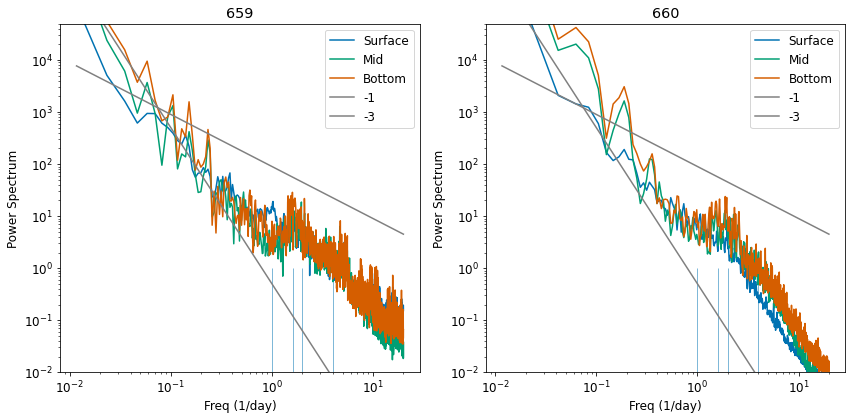

In [108]:
plt.figure(figsize=(12,6))

plt.subplot(121)
pres_spec_659_iso.sel(potdens=slice(1026, 1027.3)).mean('potdens').plot(label='Surface')
pres_spec_659_iso.sel(potdens=slice(1027.3, 1027.6)).mean('potdens').plot(label='Mid')
pres_spec_659_iso.sel(potdens=slice(1027.6, 1027.9)).mean('potdens').plot(label='Bottom')


plt.plot(temp_spec_659.freq_time, 0.9e2*temp_spec_659.freq_time**(-1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 0.5e0*temp_spec_659.freq_time**-3, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-2, 5e4])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum')
plt.title('659')
plt.legend()

plt.subplot(122)
pres_spec_660_iso.sel(potdens=slice(1026, 1027.3)).mean('potdens').plot(label='Surface')
pres_spec_660_iso.sel(potdens=slice(1027.3, 1027.6)).mean('potdens').plot(label='Mid')
pres_spec_660_iso.sel(potdens=slice(1027.6, 1027.9)).mean('potdens').plot(label='Bottom')

plt.plot(temp_spec_659.freq_time, 0.9e2*temp_spec_659.freq_time**(-1), label='-1', color='gray')
plt.plot(temp_spec_659.freq_time, 0.5e0*temp_spec_659.freq_time**-3, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-2, 5e4])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum')
plt.title('660')
plt.legend()

plt.tight_layout()

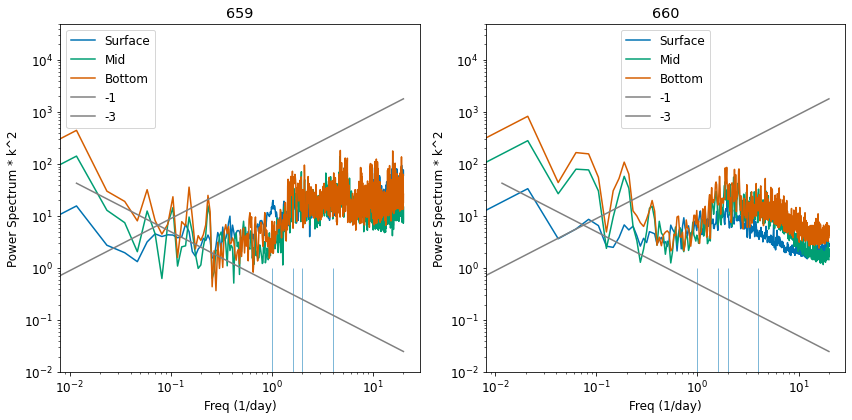

In [121]:
plt.figure(figsize=(12,6))

plt.subplot(121)
(pres_spec_659_iso.freq_time**2 * pres_spec_659_iso).sel(potdens=slice(1026, 1027.3)).mean('potdens').plot(label='Surface')
(pres_spec_659_iso.freq_time**2 * pres_spec_659_iso).sel(potdens=slice(1027.3, 1027.6)).mean('potdens').plot(label='Mid')
(pres_spec_659_iso.freq_time**2 * pres_spec_659_iso).sel(potdens=slice(1027.6, 1027.9)).mean('potdens').plot(label='Bottom')


plt.plot(temp_spec_659_iso.freq_time, 0.9e2*temp_spec_659_iso.freq_time**(1), label='-1', color='gray')
plt.plot(temp_spec_659_iso.freq_time, 0.5e0*temp_spec_659_iso.freq_time**-1, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-2, 5e4])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum * k^2')
plt.title('659')
plt.legend()

plt.subplot(122)
(pres_spec_660_iso.freq_time**2 * pres_spec_660_iso).sel(potdens=slice(1026, 1027.3)).mean('potdens').plot(label='Surface')
(pres_spec_660_iso.freq_time**2 * pres_spec_660_iso).sel(potdens=slice(1027.3, 1027.6)).mean('potdens').plot(label='Mid')
(pres_spec_660_iso.freq_time**2 * pres_spec_660_iso).sel(potdens=slice(1027.6, 1027.9)).mean('potdens').plot(label='Bottom')

plt.plot(temp_spec_659_iso.freq_time, 0.9e2*temp_spec_659_iso.freq_time**(1), label='-1', color='gray')
plt.plot(temp_spec_659_iso.freq_time, 0.5e0*temp_spec_659_iso.freq_time**-1, label='-3', color='gray')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(6/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-2, 5e4])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum * k^2')
plt.title('660')
plt.legend()

plt.tight_layout()

## Wavenumber Spectra

Over the straight section.